In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("EcommerceDataVisualization").getOrCreate()

# File path to your CSV data on S3
file_path = "s3://first-bucket-rawdata/adbms/2019-Oct.csv"

# Read CSV data into a PySpark DataFrame
ecommerce_data = spark.read.csv(file_path, header=True, inferSchema=True)

# Display schema
ecommerce_data.printSchema()

# Display first few rows
ecommerce_data.show(5, truncate=False)

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1702064653747_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |44600062  |2103807459595387724|null                               |shiseido|35.79  |541312140|72

In [2]:
# Count the total number of rows before cleaning
total_rows_before = ecommerce_data.count()
print(f"Total number of rows before cleaning: {total_rows_before}")

# Data Cleaning: Remove rows with missing values
ecommerce_data_cleaned = ecommerce_data.dropna()

# Count the total number of rows after cleaning
total_rows_after = ecommerce_data_cleaned.count()
print(f"Total number of rows after cleaning: {total_rows_after}")

# Display the count of dropped values
dropped_rows_count = total_rows_before - total_rows_after
print(f"Number of rows dropped during cleaning: {dropped_rows_count}")

# Display the cleaned DataFrame
ecommerce_data_cleaned.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of rows before cleaning: 42448764
Total number of rows after cleaning: 26560620
Number of rows dropped during cleaning: 15888144
+-------------------+----------+----------+-------------------+-----------------------------------+------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua  |33.2   |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01|view      |1307067   |2053013558920217191|computers.notebook                 |lenovo|251.74 |550050854|7c90fc70-0e80-4590-96f3-13c02c18c713|
|2019-10-01 00:00:04|view      |1004237   |20530

In [3]:
sc = spark.sparkContext
sc.install_pypi_package("matplotlib", "https://pypi.org/simple")
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

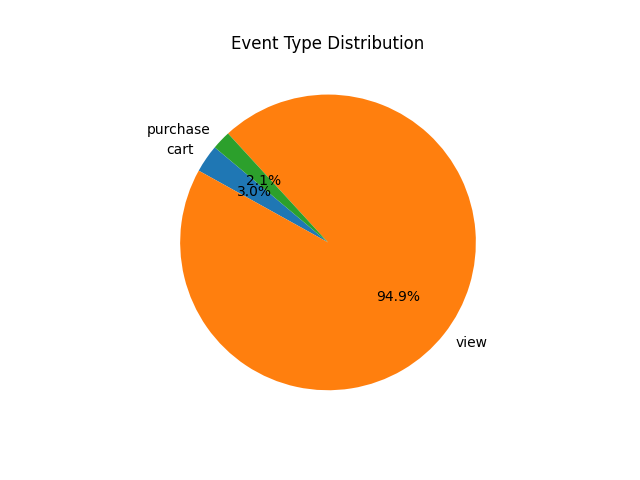

In [5]:
# Bar chart of event types
event_type_counts = ecommerce_data_cleaned.groupBy("event_type").count().toPandas()
plt.clf()
plt.pie(event_type_counts['count'], labels=event_type_counts['event_type'], autopct='%1.1f%%', startangle=140)
plt.title('Event Type Distribution')
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

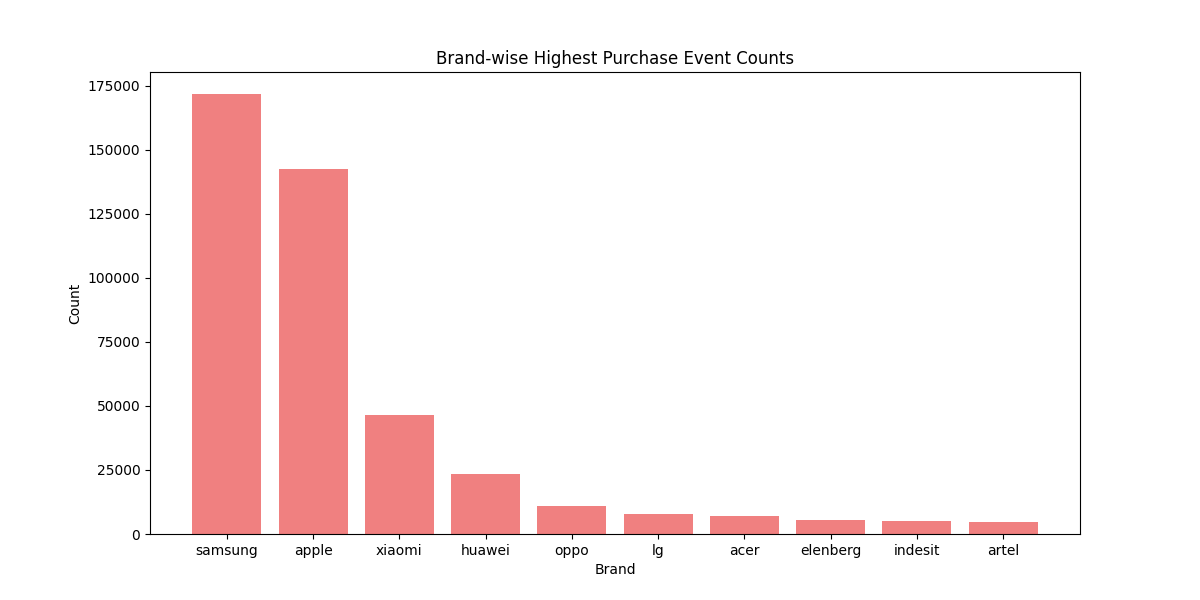

In [6]:
# Filter the DataFrame for the "purchase" event type
purchase_counts = ecommerce_data_cleaned.filter("event_type == 'purchase'").groupBy("brand").count().orderBy('count', ascending=False).limit(10).toPandas()
plt.clf()
# Plot the bar chart for Brand-wise highest Purchase Event Counts
plt.figure(figsize=(12, 6))
plt.bar(purchase_counts['brand'], purchase_counts['count'], color='lightcoral')
plt.title('Brand-wise Highest Purchase Event Counts')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

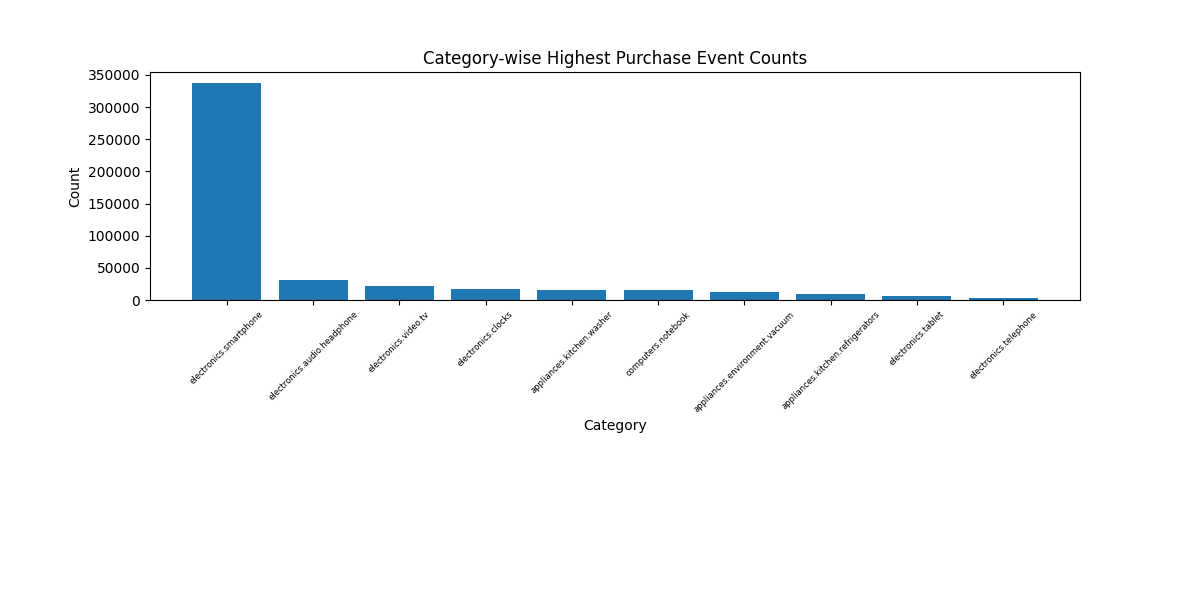

In [13]:
# Filter the DataFrame for the "purchase" event type
purchase_counts = ecommerce_data_cleaned.filter("event_type == 'purchase'").groupBy("category_code").count().orderBy('count', ascending=False).limit(10).toPandas()
plt.clf()
# Plot the bar chart for Category-wise highest Purchase Event Counts
plt.figure(figsize=(12, 6))
plt.bar(purchase_counts['category_code'], purchase_counts['count'])
plt.title('Category-wise Highest Purchase Event Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.xticks(fontsize=6)
plt.subplots_adjust(bottom=0.50)  # Increase the bottom margin
plt.show()
%matplot plt

In [16]:
from pyspark.sql.functions import col, count, date_format

# Drop duplicates and count occurrences
visitor = ecommerce_data_cleaned.withColumn("event_time", ecommerce_data_cleaned["event_time"].cast("timestamp")).dropDuplicates(['event_time', 'user_id']).groupBy(date_format("event_time", "yyyy-MM-dd").alias("event_time")).agg(count("user_id").alias("count")).sort("event_time").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

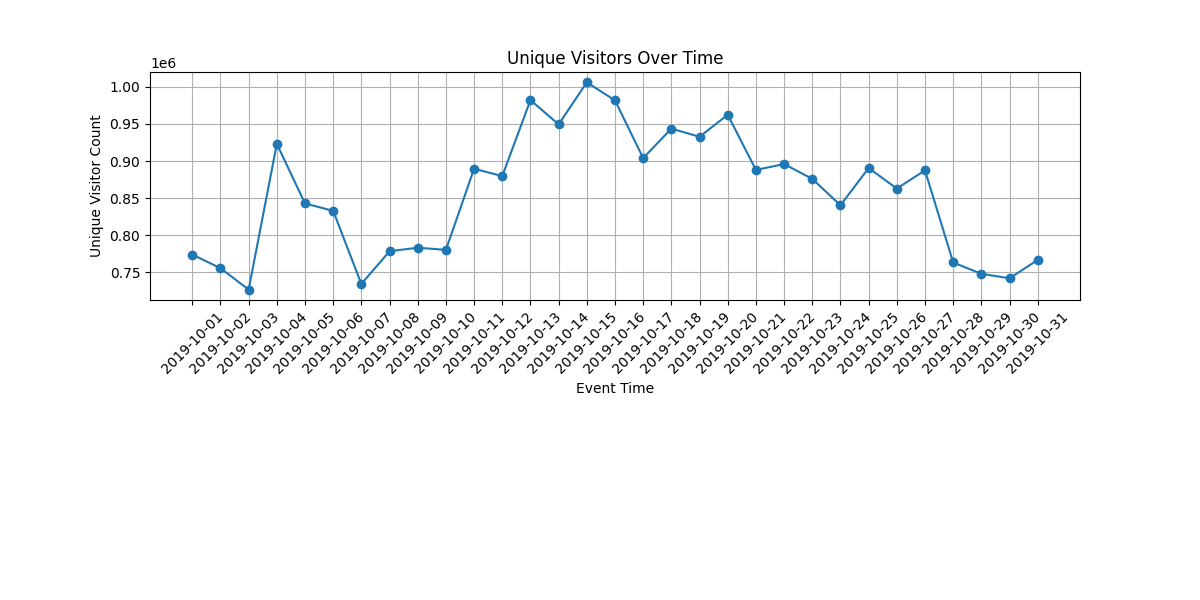

In [20]:
# Plot the chart
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(visitor['event_time'], visitor['count'], marker='o')
plt.title('Unique Visitors Over Time')
plt.xlabel('Event Time')
plt.ylabel('Unique Visitor Count')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.subplots_adjust(bottom=0.50)  # Increase the bottom margin
plt.show()
%matplot plt